[I 2025-08-05 05:16:28,273] A new study created in memory with name: no-name-62a69d25-ad9e-4ffd-a1cb-4f8c4853e803
[I 2025-08-05 05:16:28,406] Trial 0 finished with value: -5.0 and parameters: {'n_estimators': 180, 'max_samples': 0.8683304841253587, 'contamination': 0.09383101139785903, 'max_features': 0.7093249667957302}. Best is trial 0 with value: -5.0.
[I 2025-08-05 05:16:28,515] Trial 1 finished with value: -6.0 and parameters: {'n_estimators': 149, 'max_samples': 0.8640392844180225, 'contamination': 0.09781738273913959, 'max_features': 0.5097584958684485}. Best is trial 0 with value: -5.0.
[I 2025-08-05 05:16:28,637] Trial 2 finished with value: -3.0 and parameters: {'n_estimators': 177, 'max_samples': 0.5277364261469388, 'contamination': 0.0523511575676548, 'max_features': 0.8846965993643605}. Best is trial 2 with value: -3.0.
[I 2025-08-05 05:16:28,745] Trial 3 finished with value: -2.0 and parameters: {'n_estimators': 152, 'max_samples': 0.6627568734188963, 'contamination': 0.0

Best parameters for isolation forest:
{'n_estimators': 109, 'max_samples': 0.5387816055707858, 'contamination': 0.01238975578168609, 'max_features': 0.7023356304677993}


[I 2025-08-05 05:16:30,440] Trial 28 finished with value: -9.0 and parameters: {'nu': 0.055289961134717944, 'gamma': 'auto'}. Best is trial 8 with value: -5.0.
[I 2025-08-05 05:16:30,444] Trial 29 finished with value: -8.0 and parameters: {'nu': 0.060127782307287006, 'gamma': 'scale'}. Best is trial 8 with value: -5.0.
[I 2025-08-05 05:16:30,448] Trial 30 finished with value: -9.0 and parameters: {'nu': 0.07161846351261777, 'gamma': 'auto'}. Best is trial 8 with value: -5.0.
[I 2025-08-05 05:16:30,453] Trial 31 finished with value: -10.0 and parameters: {'nu': 0.035112389463549, 'gamma': 'auto'}. Best is trial 8 with value: -5.0.
[I 2025-08-05 05:16:30,457] Trial 32 finished with value: -7.0 and parameters: {'nu': 0.024966090038073978, 'gamma': 'auto'}. Best is trial 8 with value: -5.0.
[I 2025-08-05 05:16:30,462] Trial 33 finished with value: -8.0 and parameters: {'nu': 0.0379656059924214, 'gamma': 'auto'}. Best is trial 8 with value: -5.0.
[I 2025-08-05 05:16:30,468] Trial 34 finishe

Best parameters for one-class SVM:
{'nu': 0.028833270055175646, 'gamma': 'auto'}


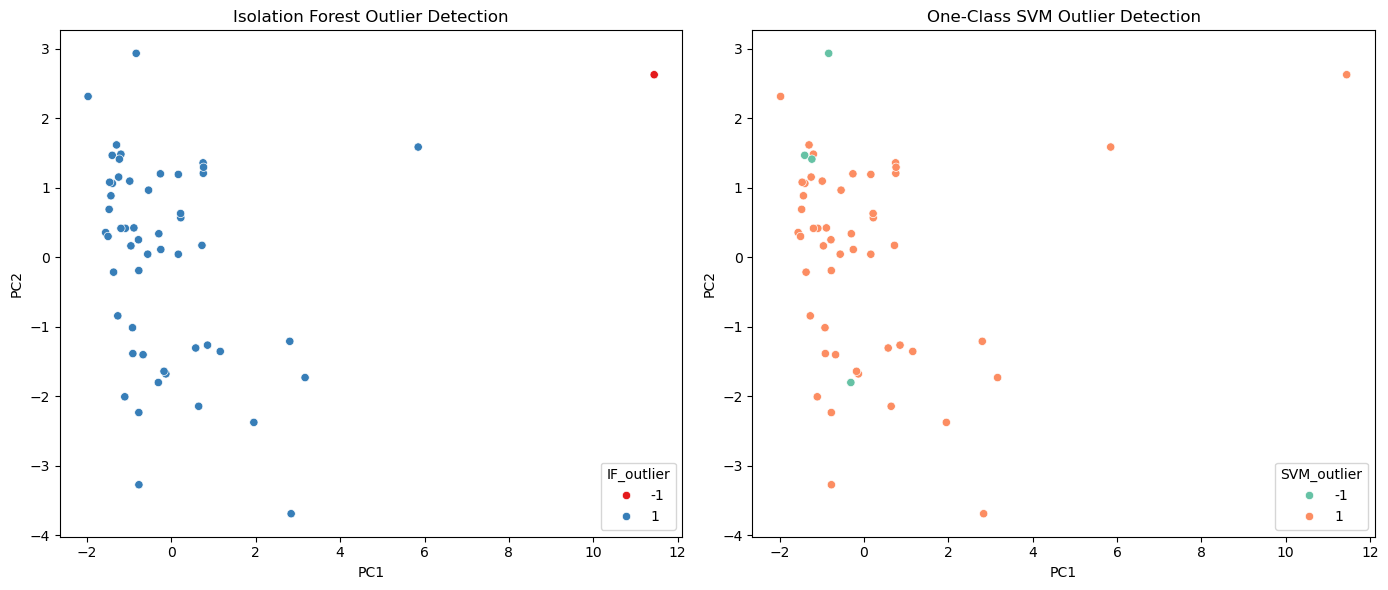

Isolation Forest Outliers:
IF_outlier
 1    53
-1     1
Name: count, dtype: int64

One-Class SVM Outliers:
SVM_outlier
 1    50
-1     4
Name: count, dtype: int64
Outlier predictions saved to Outlier_Predictions.csv


In [5]:
#02_Modeling_Outliers.ipynb

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
import optuna
import optuna.visualization as vis

#Load cleaned data
data_path = 'CR6_cleaned_scaled.csv'
df = pd.read_csv(data_path)

#Identify text and numeric columns
text_cols = ['Bankname', 'Tablename', 'Exposureclass']
numeric_cols = [col for col in df.columns if col not in text_cols]

#Added PCA for visualisation of outliers
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[numeric_cols])
df_pca = pd.DataFrame(pca_result, columns=['PC1', 'PC2'])

#Perform hyperparameter optimisation for the isolation forest
#Isolation forest is a decision tree-based unsupervised machine learning algorithm used in outlier detection
#It is based on how many splits it takes to isolate each point. If there is a short path it is likely an outlier.
def optimize_if(trial):
    n_estimators = trial.suggest_int('n_estimators', 50, 200)
    max_samples = trial.suggest_float('max_samples', 0.5, 1.0)
    contamination = trial.suggest_float('contamination', 0.01, 0.1)
    max_features = trial.suggest_float('max_features', 0.5, 1.0)

    model = IsolationForest(
        n_estimators=n_estimators,
        max_samples=max_samples,
        contamination=contamination,
        max_features=max_features,
        random_state=42
    )
    preds = model.fit_predict(df[numeric_cols])
    outlier_count = np.sum(preds == -1)
    return -outlier_count  # Objective: find settings that minimize outliers

study_if = optuna.create_study(direction='maximize')
study_if.optimize(optimize_if, n_trials=20)

print("Best parameters for isolation forest:")
print(study_if.best_params)

#Fit the optimised isolation forest
iso_model = IsolationForest(**study_if.best_params, random_state=42)
df['IF_outlier'] = iso_model.fit_predict(df[numeric_cols])

#Perform hyperparameter optimisation for one-class SVM
#One-class SVM is a kernel-based unsupervised machine learning algorithm that learns the boundary of normal
#data and flags any data points that are outside of this boundary
def optimize_svm(trial):
    nu = trial.suggest_float('nu', 0.01, 0.1)
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    model = OneClassSVM(kernel='rbf', gamma=gamma, nu=nu)
    preds = model.fit_predict(df[numeric_cols])
    outlier_count = np.sum(preds == -1)
    return -outlier_count  # Minimize outliers

#optuna runs trials using different hyperparameter combinations
#It then uses Bayesian optimisation to try different values to get better results
#It improves the scores with each trial and after a set number of trials reports the best hyperparameters
#The number of trials can be modified, but 100 were used here as a test. 
#The optimal results and the weighting of the importance of each hyperparameter can be seen in the plots below.
study_svm = optuna.create_study(direction='maximize')
study_svm.optimize(optimize_svm, n_trials=100)

opt_history_if = vis.plot_optimization_history(study_if)
opt_history_if.show()

hyp_importance_if = vis.plot_param_importances(study_if)
hyp_importance_if.show()

opt_history_svm = vis.plot_optimization_history(study_svm)
opt_history_svm.show()

hyp_importance_svm = vis.plot_param_importances(study_svm)
hyp_importance_svm.show()

print("Best parameters for one-class SVM:")
print(study_svm.best_params)

#Fit optimised One-Class SVM
ocsvm_model = OneClassSVM(**study_svm.best_params)
df['SVM_outlier'] = ocsvm_model.fit_predict(df[numeric_cols])

#Visualize outliers
#Items with score -1 are outliers, items with score 1 are not outliers
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

#Isolation forest PCA plot
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df['IF_outlier'], ax=axes[0], palette='Set1')
axes[0].set_title('Isolation Forest Outlier Detection')

#One-Class SVM PCA plot
sns.scatterplot(x=df_pca['PC1'], y=df_pca['PC2'], hue=df['SVM_outlier'], ax=axes[1], palette='Set2')
axes[1].set_title('One-Class SVM Outlier Detection')

plt.tight_layout()
plt.show()

#Summary of outliers
print("Isolation Forest Outliers:")
print(df['IF_outlier'].value_counts())

print("\nOne-Class SVM Outliers:")
print(df['SVM_outlier'].value_counts())

# Save Results
outlier_result_path = 'Outlier_Predictions.csv'
df.to_csv(outlier_result_path, index=False)
print(f"Outlier predictions saved to {outlier_result_path}")



In [7]:
#testing model stability using K-Fold CCV - this checks that the number of outliers is identified
#consistently across folds
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
outlier_counts = []

for train_idx, test_idx in kf.split(df[numeric_cols]):
    X_train, X_test = df.iloc[train_idx][numeric_cols], df.iloc[test_idx][numeric_cols]
    model = IsolationForest(contamination=0.05, random_state=42)
    model.fit(X_train)
    preds = model.predict(X_test)
    outlier_count = np.sum(preds == -1)
    outlier_counts.append(outlier_count)

print("Outlier counts per fold:", outlier_counts)





Outlier counts per fold: [0, 1, 0, 2, 0]
